## Data Reading

In [3]:
# first stab at creating a function to parse lines.  Note that this causes warnings a few cells down
processLine =
function(x)
{
  tokens = strsplit(x, "[;=,]")[[1]]
  tmp = matrix(tokens[ - (1:10) ], ncol = 4, byrow = TRUE)
  cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp),
               ncol = 6, byrow = TRUE), tmp)
}

In [1]:
# re do our data read combining all the anlysis we did here there are 7 SEVEN macids
readData = 
  function(filename = 'offline.final.trace.txt', 
           subMacs = c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a",
                       "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d",
                       "00:14:bf:b1:97:81"))
  {
    txt = readLines(filename)
    lines = txt[ substr(txt, 1, 1) != "#" ]
    tmp = lapply(lines, processLine)
    offline = as.data.frame(do.call("rbind", tmp), 
                            stringsAsFactors= FALSE) 
    
    names(offline) = c("time", "scanMac", 
                       "posX", "posY", "posZ", "orientation", 
                       "mac", "signal", "channel", "type")
    
     # keep only signals from access points
    offline = offline[ offline$type == "3", ]
    
    # drop scanMac, posZ, channel, and type - no info in them
    dropVars = c("scanMac", "posZ", "channel", "type")
    offline = offline[ , !( names(offline) %in% dropVars ) ]
    
    # drop more unwanted access points
    offline = offline[ offline$mac %in% subMacs, ]
    
    # convert numeric values
    numVars = c("time", "posX", "posY", "orientation", "signal")
    offline[ numVars ] = lapply(offline[ numVars ], as.numeric)

    # convert time to POSIX
    offline$rawTime = offline$time
    offline$time = offline$time/1000
    class(offline$time) = c("POSIXt", "POSIXct")
    
    # round orientations to nearest 45
    offline$angle = roundOrientation(offline$orientation)
      
    return(offline)
  }


In [5]:
# create a function that will round off to the nearest major angle
roundOrientation = function(angles) {
  refs = seq(0, by = 45, length  = 9)
  q = sapply(angles, function(o) which.min(abs(o - refs)))
  c(refs[1:8], 0)[q]
}

# we built it, now apply it
#offline$angle = roundOrientation(offline$orientation)


In [6]:
# implement our function
offline = readData()

Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
"data length exceeds size of matrix"
Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
"data length exceeds size of matrix"
Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
"data length exceeds size of matrix"
Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
"data length exceeds size of matrix"
Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
"data length exceeds size of matrix"
Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
"data length exceeds size of matrix"


In [7]:
# apply the variable names
#offline[ numVars ] =  lapply(offline[ numVars ], as.numeric)

#offline = offline[ offline$type == "3", ]
#offline = offline[ , "type" != names(offline) ]
dim(offline)

[1] 914951      8

In [15]:
head(offline)

,time,posX,posY,orientation,mac,signal,rawTime,angle
,<dttm>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dttm>,<dbl>
1,2006-02-11 01:31:58,0,0,0,00:14:bf:b1:97:8a,-38,2006-02-11 01:31:58,0
2,2006-02-11 01:31:58,0,0,0,00:14:bf:b1:97:90,-56,2006-02-11 01:31:58,0
3,2006-02-11 01:31:58,0,0,0,00:0f:a3:39:e1:c0,-53,2006-02-11 01:31:58,0
4,2006-02-11 01:31:58,0,0,0,00:14:bf:b1:97:8d,-65,2006-02-11 01:31:58,0
5,2006-02-11 01:31:58,0,0,0,00:14:bf:b1:97:81,-65,2006-02-11 01:31:58,0
6,2006-02-11 01:31:58,0,0,0,00:14:bf:3b:c7:c6,-66,2006-02-11 01:31:58,0


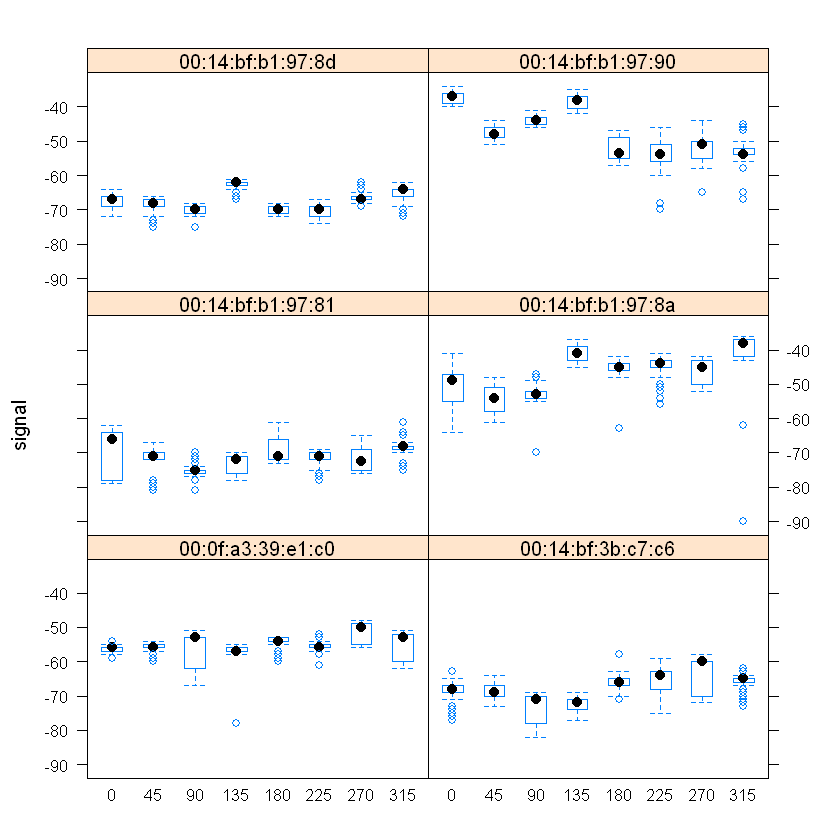

In [14]:
# plot signal strength for each device
# poor mac id 7.  he gets dropped
library(lattice)
bwplot(signal ~ factor(angle) | mac, data = offline, 
       subset = posX == 2 & posY == 12 
                & mac != "00:0f:a3:39:dd:cd", 
       layout = c(2,3))

In [8]:
unique(offline$mac)

[1] "00:14:bf:b1:97:8a" "00:14:bf:b1:97:90" "00:0f:a3:39:e1:c0"
[4] "00:14:bf:b1:97:8d" "00:14:bf:b1:97:81" "00:14:bf:3b:c7:c6"
[7] "00:0f:a3:39:dd:cd"

In [16]:
#Setup all the data using the data summary
offline$posXY = paste(offline$posX, offline$posY, sep = "-")

byLocAngleAP = with(offline, 
                    by(offline, list(posXY, angle, mac), 
                       function(x) x))

signalSummary = 
  lapply(byLocAngleAP,            
         function(oneLoc) {
           ans = oneLoc[1, ]
           ans$medSignal = median(oneLoc$signal)
           ans$avgSignal = mean(oneLoc$signal)
           ans$num = length(oneLoc$signal) 
           ans$sdSignal = sd(oneLoc$signal)
           ans$iqrSignal = IQR(oneLoc$signal)
           ans
           })

offlineSummary = do.call("rbind", signalSummary)     

In [17]:
unique(offlineSummary$mac)

[1] "00:0f:a3:39:dd:cd" "00:0f:a3:39:e1:c0" "00:14:bf:3b:c7:c6"
[4] "00:14:bf:b1:97:81" "00:14:bf:b1:97:8a" "00:14:bf:b1:97:8d"
[7] "00:14:bf:b1:97:90"

In [19]:
subMacs = names(sort(table(offline$mac), decreasing = TRUE))[1:7]
subMacs

[1] "00:0f:a3:39:e1:c0" "00:0f:a3:39:dd:cd" "00:14:bf:b1:97:8a"
[4] "00:14:bf:3b:c7:c6" "00:14:bf:b1:97:90" "00:14:bf:b1:97:8d"
[7] "00:14:bf:b1:97:81"

In [20]:
# option1 where we drop a macid "'00:0f:a3:39:dd:cd'"
offlineSummary_t1 = subset(offlineSummary, mac != subMacs[2])

# option2 where we drop a macid "'00:0f:a3:39:e1:c0'"
offlineSummary_t2 = subset(offlineSummary, mac != subMacs[1])

#### Read in Online Data

In [22]:
# tally signal strength

macs = unique(offlineSummary$mac)
online = readData("online.final.trace.txt", subMacs = macs)

online$posXY = paste(online$posX, online$posY, sep = "-")

length(unique(online$posXY))

tabonlineXYA = table(online$posXY, online$angle)
tabonlineXYA[1:6, ]

[1] 60

            
               0  45  90 135 180 225 270 315
  0-0.05       0   0   0 704   0   0   0   0
  0.15-9.42    0   0 717   0   0   0   0   0
  0.31-11.09   0   0   0   0   0 684   0   0
  0.47-8.2   701   0   0   0   0   0   0   0
  0.78-10.94 695   0   0   0   0   0   0   0
  0.93-11.69   0   0   0   0 691   0   0   0

In [33]:
keepVars = c("posXY", "posX","posY", "orientation", "angle")
byLoc = with(online, 
             by(online, list(posXY), 
                function(x) {
                  ans = x[1, keepVars]
                  avgSS = tapply(x$signal, x$mac, mean)
                  y = matrix(avgSS, nrow = 1, ncol = 7,
                        dimnames = list(ans$posXY, names(avgSS)))
                  cbind(ans, y)
                }))
onlineSummary = do.call("rbind", byLoc)  

In [68]:
# option1 where we drop a macid "'00:0f:a3:39:dd:cd'"
online1 = online[ online$mac != "00:0f:a3:39:dd:cd", ]
byLoc1 = with(online1, 
             by(online1, list(posXY), 
                function(x) {
                  ans = x[1, keepVars]
                  avgSS = tapply(x$signal, x$mac, mean)
                  y = matrix(avgSS, nrow = 1, ncol = 6,
                        dimnames = list(ans$posXY, names(avgSS)))
                  cbind(ans, y)
                }))

onlineSummary_t1 = do.call("rbind", byLoc1)  



In [69]:
onlineSummary_t1

,posXY,posX,posY,orientation,angle,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0-0.05,0-0.05,0.00,0.05,130.5,135,-52.22727,-62.94898,-61.81395,-40.06897,-63.04301,-55.23333
0.15-9.42,0.15-9.42,0.15,9.42,112.3,90,-55.27523,-73.96190,-72.70103,-47.81308,-69.45455,-46.88000
0.31-11.09,0.31-11.09,0.31,11.09,230.1,225,-51.70909,-70.08247,-70.09890,-54.08824,-69.13158,-53.88660
0.47-8.2,0.47-8.2,0.47,8.20,5.8,0,-49.50000,-64.25806,-72.59770,-45.65289,-60.79747,-49.58000
0.78-10.94,0.78-10.94,0.78,10.94,348.3,0,-53.26364,-66.96000,-66.80952,-48.41379,-65.00000,-54.84694
0.93-11.69,0.93-11.69,0.93,11.69,158.3,180,-57.96364,-70.44340,-70.58025,-43.66346,-65.59302,-47.27083
1.08-12.19,1.08-12.19,1.08,12.19,229.1,225,-54.82727,-69.20192,-67.92553,-52.00820,-71.58696,-51.66667
1.24-3.93,1.24-3.93,1.24,3.93,261.5,270,-56.47273,-69.62745,-59.76136,-38.91753,-71.66667,-53.23333
1.39-6.61,1.39-6.61,1.39,6.61,114.1,135,-51.28182,-62.23913,-64.56627,-48.92381,-60.79798,-50.49057


In [70]:
# option2 where we drop a macid "'00:0f:a3:39:e1:c0'"
online2 = online[ online$mac != "00:0f:a3:39:e1:c0", ]

byLoc2 = with(online2, 
             by(online2, list(posXY), 
                function(x) {
                  ans = x[1, keepVars]
                  avgSS = tapply(x$signal, x$mac, mean)
                  y = matrix(avgSS, nrow = 1, ncol = 6,
                        dimnames = list(ans$posXY, names(avgSS)))
                  cbind(ans, y)
                }))

onlineSummary_t2 = do.call("rbind", byLoc2)  
onlineSummary_t2

,posXY,posX,posY,orientation,angle,00:0f:a3:39:dd:cd,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0-0.05,0-0.05,0.00,0.05,130.5,135,-63.20721,-62.94898,-61.81395,-40.06897,-63.04301,-55.23333
0.15-9.42,0.15-9.42,0.15,9.42,112.3,90,-66.11712,-73.96190,-72.70103,-47.81308,-69.45455,-46.88000
0.31-11.09,0.31-11.09,0.31,11.09,230.1,225,-67.05405,-70.08247,-70.09890,-54.08824,-69.13158,-53.88660
0.47-8.2,0.47-8.2,0.47,8.20,5.8,0,-74.15315,-64.25806,-72.59770,-45.65289,-60.79747,-49.58000
0.78-10.94,0.78-10.94,0.78,10.94,348.3,0,-71.40367,-66.96000,-66.80952,-48.41379,-65.00000,-54.84694
0.93-11.69,0.93-11.69,0.93,11.69,158.3,180,-69.99074,-70.44340,-70.58025,-43.66346,-65.59302,-47.27083
1.08-12.19,1.08-12.19,1.08,12.19,229.1,225,-73.43750,-69.20192,-67.92553,-52.00820,-71.58696,-51.66667
1.24-3.93,1.24-3.93,1.24,3.93,261.5,270,-71.11009,-69.62745,-59.76136,-38.91753,-71.66667,-53.23333
1.39-6.61,1.39-6.61,1.39,6.61,114.1,135,-59.75676,-62.23913,-64.56627,-48.92381,-60.79798,-50.49057


In [44]:
# create data frame and functions to aggregate/select data with similar angles
dim(onlineSummary)

names(onlineSummary)
m = 3; angleNewObs = 230
refs = seq(0, by = 45, length  = 8)
nearestAngle = roundOrientation(angleNewObs)
  
if (m %% 2 == 1) {
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
} else {
  m = m + 1
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  if (sign(angleNewObs - nearestAngle) > -1) 
    angles = angles[ -1 ]
  else 
    angles = angles[ -m ]
}
angles = angles + nearestAngle
angles[angles < 0] = angles[ angles < 0 ] + 360
angles[angles > 360] = angles[ angles > 360 ] - 360

offlineSubset = 
  offlineSummary[ offlineSummary$angle %in% angles, ]

reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY")) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = length(unique(data$mac)),
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

[1] 60 12

[1] "posXY"             "posX"              "posY"             
 [4] "orientation"       "angle"             "00:0f:a3:39:dd:cd"
 [7] "00:0f:a3:39:e1:c0" "00:14:bf:3b:c7:c6" "00:14:bf:b1:97:81"
[10] "00:14:bf:b1:97:8a" "00:14:bf:b1:97:8d" "00:14:bf:b1:97:90"

## Compose Training Data for KNN

In [45]:
trainSS = reshapeSS(offlineSubset, varSignal = "avgSignal")

selectTrain = function(angleNewObs, signals = NULL, m = 1){
  # m is the number of angles to keep between 1 and 5
  refs = seq(0, by = 45, length  = 8)
  nearestAngle = roundOrientation(angleNewObs)
  
  if (m %% 2 == 1) 
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  else {
    m = m + 1
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
    if (sign(angleNewObs - nearestAngle) > -1) 
      angles = angles[ -1 ]
    else 
      angles = angles[ -m ]
  }
  angles = angles + nearestAngle
  angles[angles < 0] = angles[ angles < 0 ] + 360
  angles[angles > 360] = angles[ angles > 360 ] - 360
  angles = sort(angles) 
  
  offlineSubset = signals[ signals$angle %in% angles, ]
  reshapeSS(offlineSubset, varSignal = "avgSignal")
}


In [46]:
# here is our NN function.
findNN = function(newSignal, trainSubset) {
  diffs = apply(trainSubset[ , 4:9], 1, 
                function(x) x - newSignal)
  dists = apply(diffs, 2, function(x) sqrt(sum(x^2)) )
  closest = order(dists)
  return(trainSubset[closest, 1:3 ])
}

In [47]:
# predict X-Y based on the the neasest k neighbors (default 3)
predXY = function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    closeXY[[i]] = 
      findNN(newSignal = as.numeric(newSignals[i, ]), trainSS)
  }

  estXY = lapply(closeXY, 
                 function(x) sapply(x[ , 2:3], 
                                    function(x) mean(x[1:k])))
  estXY = do.call("rbind", estXY)
  return(estXY)
}
      

In [119]:
options(error = recover, warn = 1)
set.seed(42)

calcError = 
function(estXY, actualXY) 
   sum( rowSums( (estXY - actualXY)^2) )

actualXY = onlineSummary[ , c("posX", "posY")]
#sapply(list(estXYk1, estXYk3), calcError, actualXY)
v = 11
permuteLocs = sample(unique(offlineSummary$posXY))
permuteLocs = matrix(permuteLocs, ncol = v, 
                     nrow = floor(length(permuteLocs)/v))

onlineFold = subset(offlineSummary, posXY %in% permuteLocs[ , 1])

reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY"),
                     sampleAngle = FALSE, 
                     refs = seq(0, 315, by = 45)) {
  set.seed(42)
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    if (sampleAngle) {
                      x = x[x$angle == sample(refs, size = 1), ]}
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = length(unique(data$mac)),
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}


Warning message in matrix(permuteLocs, ncol = v, nrow = floor(length(permuteLocs)/v)):
"data length [166] is not a sub-multiple or multiple of the number of rows [15]"


### KNN Test with K points for 3 Mac Options

In [121]:
#offline = offline[ offline$mac != "00:0f:a3:39:dd:cd", ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")

onlineCVSummary = reshapeSS(offline, keepVars = keepVars, 
                            sampleAngle = TRUE)

onlineFold = subset(onlineCVSummary, 
                    posXY %in% permuteLocs[ , 1])

offlineFold = subset(offlineSummary,
                     posXY %in% permuteLocs[ , -1])

estFold = predXY(newSignals = onlineFold[ , 6:11], 
                 newAngles = onlineFold[ , 4], 
                 offlineFold, numAngles = 3, k = 3)

actualFold = onlineFold[ , c("posX", "posY")]
calcError(estFold, actualFold)

[1] 230.7778

In [123]:
offline_t1 = offline[ offline$mac != "00:0f:a3:39:dd:cd", ]

onlineCVSummary_t1 = reshapeSS(offline_t1, keepVars = keepVars, 
                            sampleAngle = TRUE)

onlineFold = subset(onlineCVSummary_t1, 
                    posXY %in% permuteLocs[ , 1])

offlineFold = subset(offlineSummary_t1,
                     posXY %in% permuteLocs[ , -1])

estFold = predXY(newSignals = onlineFold[ , 6:11], 
                 newAngles = onlineFold[ , 4], 
                 offlineFold, numAngles = 3, k = 3)

actualFold = onlineFold[ , c("posX", "posY")]
calcError(estFold, actualFold)

[1] 154.5556

In [124]:
offline_t2 = offline[ offline$mac != "00:0f:a3:39:e1:c0", ]

onlineCVSummary_t2 = reshapeSS(offline_t2, keepVars = keepVars, 
                            sampleAngle = TRUE)

onlineFold = subset(onlineCVSummary_t2, 
                    posXY %in% permuteLocs[ , 1])

offlineFold = subset(offlineSummary_t2,
                     posXY %in% permuteLocs[ , -1])

estFold = predXY(newSignals = onlineFold[ , 6:11], 
                 newAngles = onlineFold[ , 4], 
                 offlineFold, numAngles = 3, k = 3)

actualFold = onlineFold[ , c("posX", "posY")]
calcError(estFold, actualFold)

[1] 180.3333

### KNN Test for 11 folds validation with 3 Mac Options

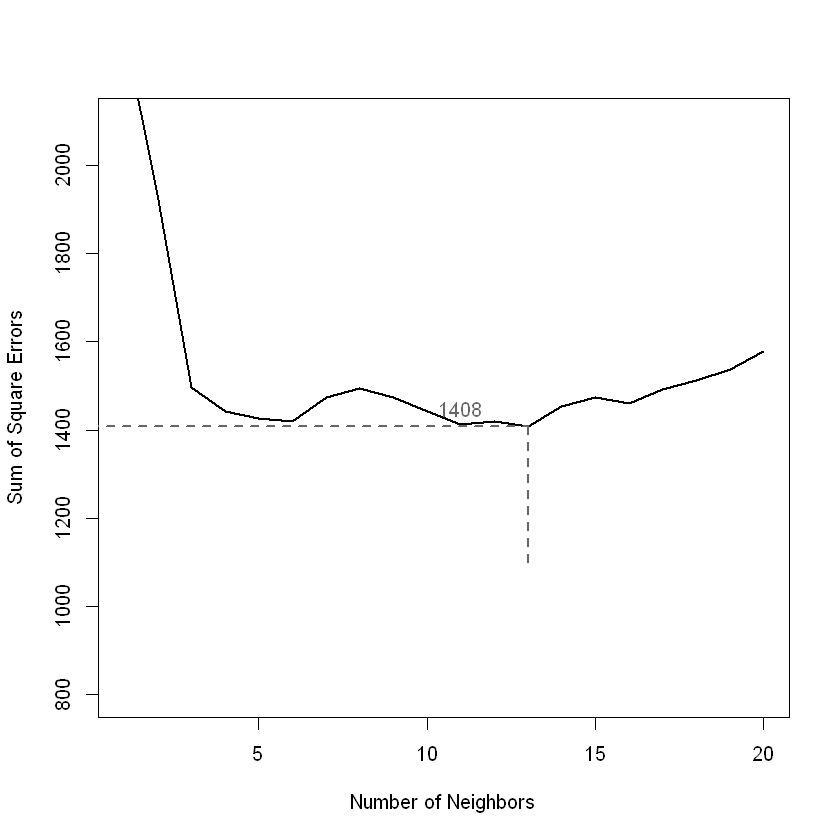

In [81]:
K = 20
err = rep(0, K)

for (j in 1:v) {
  onlineFold = subset(onlineCVSummary_t2, 
                      posXY %in% permuteLocs[ , j])
  offlineFold = subset(offlineSummary_t2,
                       posXY %in% permuteLocs[ , -j])
  actualFold = onlineFold[ , c("posX", "posY")]
  
  for (k in 1:K) {
    estFold = predXY(newSignals = onlineFold[ , 6:11],
                     newAngles = onlineFold[ , 4], 
                     offlineFold, numAngles = 1, k = k)
    err[k] = err[k] + calcError(estFold, actualFold)
  }
}


plot(y = err, x = (1:K),  type = "l", lwd= 2,
     ylim = c(800, 2100),
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")

rmseMin = min(err)
kMin = which(err == rmseMin)[1]
rmseMin
kMin

segments(x0 = 0, x1 = kMin, y0 = rmseMin, col = gray(0.4), 
         lty = 2, lwd = 2)
segments(x0 = kMin, x1 = kMin, y0 = 1100,  y1 = rmseMin, 
         col = grey(0.4), lty = 2, lwd = 2)

text(x = kMin - 2, y = rmseMin + 40, 
     label = as.character(round(rmseMin)), col = grey(0.4))

onlineFold = subset(onlineCVSummary_t2, 
                    posXY %in% permuteLocs[ , 1])

offlineFold = subset(offlineSummary_t2,
                     posXY %in% permuteLocs[ , -1])

estFold = predXY(newSignals = onlineFold[ , 6:11], 
                 newAngles = onlineFold[ , 4], 
                 offlineFold, numAngles = 1, k = kMin)

actualFold = onlineFold[ , c("posX", "posY")]
calcError(estFold, actualFold)

[1] 1086.125

[1] 8

[1] 136.3281

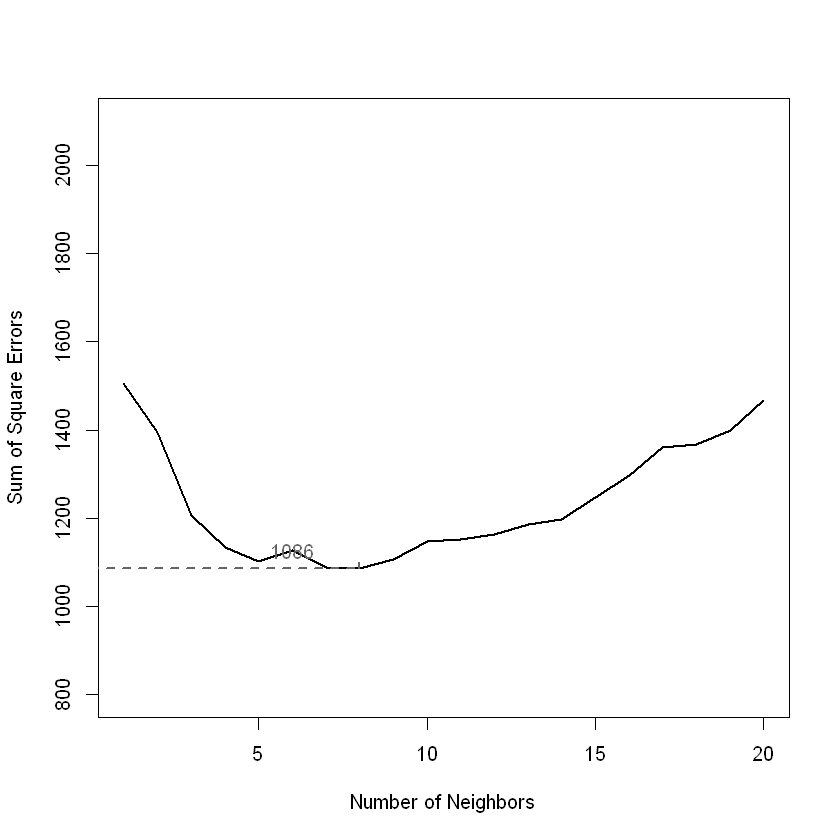

In [131]:
K = 20
err = rep(0, K)

for (j in 1:v) {
  onlineFold = subset(onlineCVSummary_t2, 
                      posXY %in% permuteLocs[ , j])
  offlineFold = subset(offlineSummary_t2,
                       posXY %in% permuteLocs[ , -j])
  actualFold = onlineFold[ , c("posX", "posY")]
  
  for (k in 1:K) {
    estFold = predXY(newSignals = onlineFold[ , 6:11],
                     newAngles = onlineFold[ , 4], 
                     offlineFold, numAngles = 3, k = k)
    err[k] = err[k] + calcError(estFold, actualFold)
  }
}


plot(y = err, x = (1:K),  type = "l", lwd= 2,
     ylim = c(800, 2100),
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")

rmseMin = min(err)
kMin = which(err == rmseMin)[1]
rmseMin
kMin

segments(x0 = 0, x1 = kMin, y0 = rmseMin, col = gray(0.4), 
         lty = 2, lwd = 2)
segments(x0 = kMin, x1 = kMin, y0 = 1100,  y1 = rmseMin, 
         col = grey(0.4), lty = 2, lwd = 2)

text(x = kMin - 2, y = rmseMin + 40, 
     label = as.character(round(rmseMin)), col = grey(0.4))

onlineFold = subset(onlineCVSummary_t2, 
                    posXY %in% permuteLocs[ , 1])

offlineFold = subset(offlineSummary_t2,
                     posXY %in% permuteLocs[ , -1])

estFold = predXY(newSignals = onlineFold[ , 6:11], 
                 newAngles = onlineFold[ , 4], 
                 offlineFold, numAngles = 3, k = kMin)

actualFold = onlineFold[ , c("posX", "posY")]
calcError(estFold, actualFold)

[1] 1097.833

[1] 6

[1] 168.0833

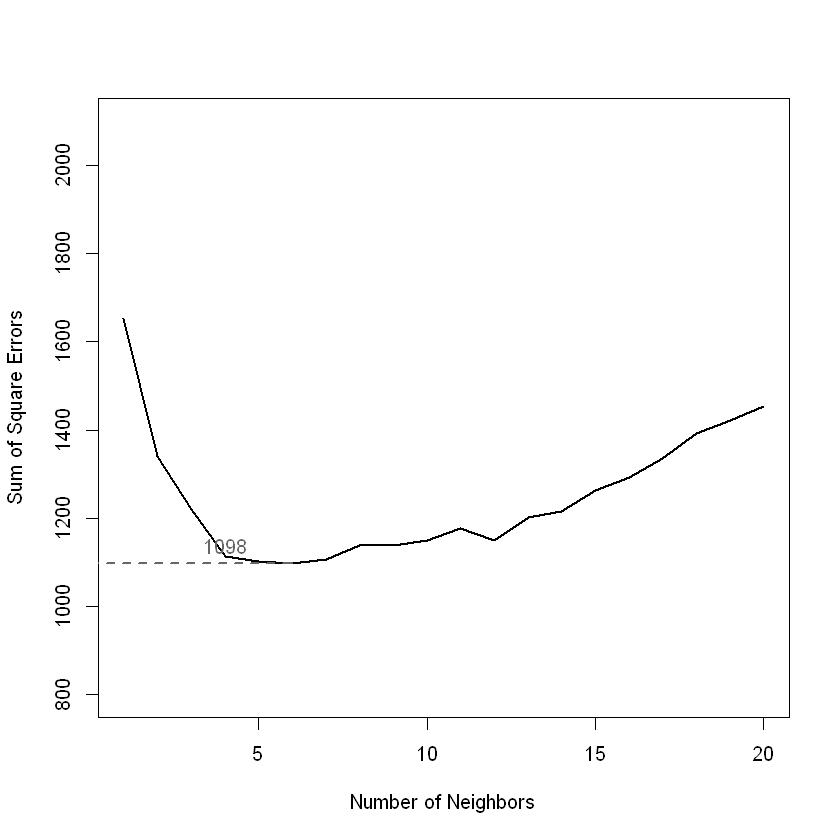

In [132]:
K = 20
err = rep(0, K)

for (j in 1:v) {
  onlineFold = subset(onlineCVSummary_t1, 
                      posXY %in% permuteLocs[ , j])
  offlineFold = subset(offlineSummary_t1,
                       posXY %in% permuteLocs[ , -j])
  actualFold = onlineFold[ , c("posX", "posY")]
  
  for (k in 1:K) {
    estFold = predXY(newSignals = onlineFold[ , 6:11],
                     newAngles = onlineFold[ , 4], 
                     offlineFold, numAngles = 3, k = k)
    err[k] = err[k] + calcError(estFold, actualFold)
  }
}


plot(y = err, x = (1:K),  type = "l", lwd= 2,
     ylim = c(800, 2100),
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")

rmseMin = min(err)
kMin = which(err == rmseMin)[1]
rmseMin
kMin

segments(x0 = 0, x1 = kMin, y0 = rmseMin, col = gray(0.4), 
         lty = 2, lwd = 2)
segments(x0 = kMin, x1 = kMin, y0 = 1100,  y1 = rmseMin, 
         col = grey(0.4), lty = 2, lwd = 2)

text(x = kMin - 2, y = rmseMin + 40, 
     label = as.character(round(rmseMin)), col = grey(0.4))

onlineFold = subset(onlineCVSummary_t1, 
                    posXY %in% permuteLocs[ , 1])

offlineFold = subset(offlineSummary_t1,
                     posXY %in% permuteLocs[ , -1])

estFold = predXY(newSignals = onlineFold[ , 6:11], 
                 newAngles = onlineFold[ , 4], 
                 offlineFold, numAngles = 3, k = kMin)

actualFold = onlineFold[ , c("posX", "posY")]
calcError(estFold, actualFold)

[1] 1239.898

[1] 7

[1] 220.449

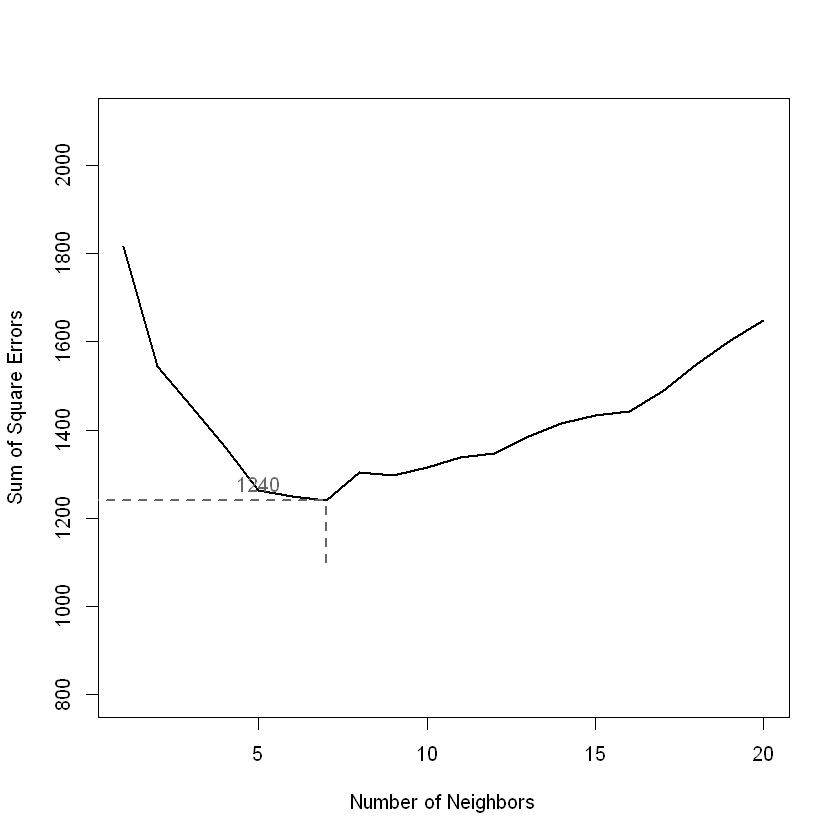

In [133]:
K = 20
err = rep(0, K)

for (j in 1:v) {
  onlineFold = subset(onlineCVSummary, 
                      posXY %in% permuteLocs[ , j])
  offlineFold = subset(offlineSummary,
                       posXY %in% permuteLocs[ , -j])
  actualFold = onlineFold[ , c("posX", "posY")]
  
  for (k in 1:K) {
    estFold = predXY(newSignals = onlineFold[ , 6:11],
                     newAngles = onlineFold[ , 4], 
                     offlineFold, numAngles = 3, k = k)
    err[k] = err[k] + calcError(estFold, actualFold)
  }
}


plot(y = err, x = (1:K),  type = "l", lwd= 2,
     ylim = c(800, 2100),
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")

rmseMin = min(err)
kMin = which(err == rmseMin)[1]
rmseMin
kMin

segments(x0 = 0, x1 = kMin, y0 = rmseMin, col = gray(0.4), 
         lty = 2, lwd = 2)
segments(x0 = kMin, x1 = kMin, y0 = 1100,  y1 = rmseMin, 
         col = grey(0.4), lty = 2, lwd = 2)

text(x = kMin - 2, y = rmseMin + 40, 
     label = as.character(round(rmseMin)), col = grey(0.4))

onlineFold = subset(onlineCVSummary, 
                    posXY %in% permuteLocs[ , 1])

offlineFold = subset(offlineSummary,
                     posXY %in% permuteLocs[ , -1])

estFold = predXY(newSignals = onlineFold[ , 6:11], 
                 newAngles = onlineFold[ , 4], 
                 offlineFold, numAngles = 3, k = kMin)

actualFold = onlineFold[ , c("posX", "posY")]
calcError(estFold, actualFold)

## KNN Weighted Test 

In [98]:
weightFormula = function(x){ 1/(x+0.000001)} #inverse of distance

findNN_W = function(newSignal, trainSubset, weighted=FALSE) {
  diffs = apply(trainSubset[ , 4:9], 1, function(x) x - newSignal)
  dists = apply(diffs, 2, function(x) sqrt(sum(x^2)) )
  closest = order(dists)
  
  ordered_dist = dists[closest]
  if(weighted == TRUE){
    weight = weightFormula(ordered_dist)
  }
  if(weighted == FALSE){
    weight = rep(1, length(dists))
  }
  return(cbind(trainSubset[closest, 1:3], ordered_dist, weight))
}
                                         

In [99]:
predXY_W = function(newSignals, newAngles, trainData, numAngles = 1, k = 3, weighted=FALSE){
  closeXY = list(length = nrow(newSignals))
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    closeXY[[i]] = findNN_W(
      newSignal = as.numeric(newSignals[i, ]),
      trainSubset = trainSS,
      weighted = weighted
    )
  }
  weighted_XY_cal = function(x, k){
    weights = x[1:k, 5]
    weighted_x = sum(x[1:k, 2] * weights) / sum(weights)
    weighted_y = sum(x[1:k, 3] * weights) / sum(weights)
    return(c(weighted_x, weighted_y))
  }
  
  # estXY = lapply(closeXY, function(x) sapply(x[ , 2:3], function(x) mean(x[1:k])))
  estXY = lapply(closeXY, weighted_XY_cal, k)
  estXY = do.call("rbind", estXY)
  return(estXY)
}

In [100]:
calcError = 
function(estXY, actualXY) 
   sum( rowSums( (estXY - actualXY)^2) )

In [109]:
set.seed(42)
permuteLocs = sample(unique(offline$posXY))
permuteLocs = matrix(permuteLocs, ncol = v, nrow = floor(length(permuteLocs)/v))

Warning message in matrix(permuteLocs, ncol = v, nrow = floor(length(permuteLocs)/v)):
"data length [166] is not a sub-multiple or multiple of the number of rows [15]"


#### Test with determined neighbour k = 3

In [111]:
offline_t1 = offline[ offline$mac != "00:0f:a3:39:dd:cd", ]

onlineCVSummary_t1 = reshapeSS(offline_t1, keepVars = keepVars, 
                            sampleAngle = TRUE)

onlineFold = subset(onlineCVSummary_t1, 
                    posXY %in% permuteLocs[ , 1])

offlineFold = subset(offlineSummary_t1,
                     posXY %in% permuteLocs[ , -1])

estFold = predXY_W(newSignals = onlineFold[ , 6:11], 
                 newAngles = onlineFold[ , 4], 
                 offlineFold, weighted=FALSE,numAngles = 3, k = 3)

actualFold = onlineFold[ , c("posX", "posY")]
calcError(estFold, actualFold)

[1] 244

In [126]:
estFold = predXY_W(newSignals = onlineFold[ , 6:11], 
                 newAngles = onlineFold[ , 4], 
                 offlineFold, weighted=TRUE,numAngles = 3, k = 3)

actualFold = onlineFold[ , c("posX", "posY")]
calcError(estFold, actualFold)

[1] 177.2206

### Test of 11 fold validation varying neighbour number k

[1] 1074.409

[1] 6

[1] 168.0833

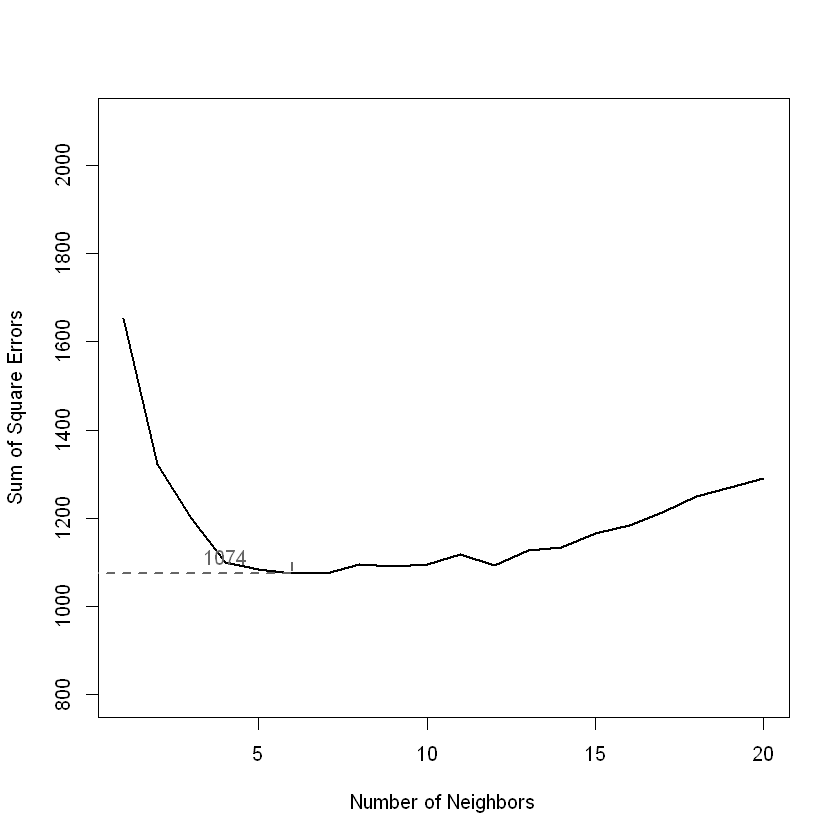

In [127]:
K = 20
err = rep(0, K)

for (j in 1:v) {
  onlineFold = subset(onlineCVSummary_t1, 
                      posXY %in% permuteLocs[ , j])
  offlineFold = subset(offlineSummary_t1,
                       posXY %in% permuteLocs[ , -j])
  actualFold = onlineFold[ , c("posX", "posY")]
  
  for (k in 1:K) {
    estFold = predXY_W(newSignals = onlineFold[ , 6:11],
                     newAngles = onlineFold[ , 4], 
                     offlineFold, weighted=TRUE, numAngles = 3, k = k)
    err[k] = err[k] + calcError(estFold, actualFold)
  }
}


plot(y = err, x = (1:K),  type = "l", lwd= 2,
     ylim = c(800, 2100),
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")

rmseMin = min(err)
kMin = which(err == rmseMin)[1]
rmseMin
kMin

segments(x0 = 0, x1 = kMin, y0 = rmseMin, col = gray(0.4), 
         lty = 2, lwd = 2)
segments(x0 = kMin, x1 = kMin, y0 = 1100,  y1 = rmseMin, 
         col = grey(0.4), lty = 2, lwd = 2)

text(x = kMin - 2, y = rmseMin + 40, 
     label = as.character(round(rmseMin)), col = grey(0.4))

onlineFold = subset(onlineCVSummary_t1, 
                    posXY %in% permuteLocs[ , 1])

offlineFold = subset(offlineSummary_t1,
                     posXY %in% permuteLocs[ , -1])

estFold = predXY(newSignals = onlineFold[ , 6:11], 
                 newAngles = onlineFold[ , 4], 
                 offlineFold, numAngles = 3, k = kMin)

actualFold = onlineFold[ , c("posX", "posY")]
calcError(estFold, actualFold)